# Implementando uma MLP básica com Grid Search para escolher os melhores parâmetros

## 1. Importando as bibliotecas necessárias

### 1.1 Bibliotecas gerais

In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # a biblioteca 'seaborn' contém vários estilos para os gráficos do 'matpĺotlib'

# agora, melhoramos a qualidade de saida e de visualizacao da imagem 
# alem de mudar a fonte padrao para uma do latex
sns.set_style("ticks")
plt.rcParams['savefig.dpi'] = 200
plt.rcParams["figure.dpi"] = 100

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.style.use('dark_background')

### 1.2 Bibliotecas para MLP

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import backend as keras_backend

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorboard.plugins.hparams import api as hp

In [4]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

### 1.3 Bibliotecas dos sistemas caóticos

In [5]:
import sys 
sys.path.insert(0, '../../../../scripts')

import timeseries as times
import lorenzsystem as lsys

## 2. Gerando a série temporal do sistema de Lorenz

Os valores para os parâmetros das equações serão os "básicos" apresentados no *paper* original.

In [6]:
t_inicial = 0
t_final = 50
dt = 0.01

In [7]:
estado_inicial = np.array([0.1, 0, 0])

In [8]:
sis_lorenz = lsys.SistemaLorenz(estado_inicial, dt=dt)

In [9]:
solucoes, instantes_temporais = sis_lorenz.calcular(t_inicial = t_inicial, t_final = t_final)

In [10]:
x = solucoes[:, 0]
y = solucoes[:, 1]
z = solucoes[:, 2]

In [11]:
fig, ax = plt.subplots(3)
fig.suptitle("Séries temporais de 0 a 100 segundos das coordenadas xyz do Sistema de Lorenz")
ax[0].plot(instantes_temporais, x, color='DeepSkyBlue')

ax[0].set_ylabel('x(t)')
ax[0].set_xlabel('t')
ax[0].set_xlim(0,)
    
ax[0].grid(True)

ax[1].plot(instantes_temporais, y, color='LightCoral')
ax[1].set_ylabel('y(t)')
ax[1].set_xlabel('t')
ax[1].set_xlim(0,)
ax[1].grid(True)

ax[2].plot(instantes_temporais, z, color='PaleGreen')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('t')
ax[2].set_xlim(0,)
ax[2].grid(True)

fig.tight_layout()
sns.despine()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### 2.1 Dividindo em um conjunto de treinamento e de teste, para K = 4 e L = 3

In [12]:
K = 4
L = 3
tam_teste = 0.15

In [13]:
serie_temporal = times.SerieTemporal(x, K=K, L=L)

In [14]:
serie_temporal.criar_matrizes()

In [15]:
X_treino, X_teste, y_treino, y_teste = serie_temporal.dividir_treino_teste(tam_teste)

## 3. Definindo o modelo para a MLP

### 3.1 Definindo função para criar a MLP

In [16]:
def criar_modelo(batch_normalization='OFF', learning_rate=0.001, activation='selu', init_mode='lecun_normal', n_neurons=30):
    
    keras_backend.clear_session()
    optimizer_gs = optimizer
    optimizer_gs.learning_rate.assign(learning_rate)
    
    model = keras.Sequential(name="MLP-1-camada-intermediaria")
    model.add(keras.layers.Dense(K, input_dim=K, name="camada_de_entrada", activation = 'linear'))
    if (batch_normalization == 'ON'):
        model.add(keras.layers.BatchNormalization(name="camada_de_batch_normalization"))
    model.add(keras.layers.Dense(n_neurons, input_dim=K, activation=activation, kernel_initializer=init_mode, name="camada_intermediaria"))
    model.add(keras.layers.Dense(1, activation='linear', name="camada_de_saida"))
    
    model.compile(
        optimizer = optimizer_gs,
        loss = loss)
    
    model.build()
    return model

Utilizaremos os seguintes parâmetros no *Grid Search*:

In [18]:
param_grid = dict(batch_size=[2, 4, 8, 16, 32], 
                  batch_normalization=['ON', 'OFF'], 
                  activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh'], 
                  init_mode = ['lecun_uniform', 'lecun_normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                  learning_rate = [0.001, 0.003, 0.005, 0.008, 0.01])

Para facilitar, dividiremos esse processo em etapas.

### 3.2 Definindo parâmetros que não serão definidos pelo *Grid Search*

In [19]:
loss = "mean_squared_error"
optimizer = keras.optimizers.Nadam()

In [20]:
early_stopping_cv = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='loss')

### 3.3 Definindo e executando o primeiro *Grid Search*

Primeiro, avaliaremos o impacto do *batch size* e da camada de *batch normalization*.

In [21]:
param_grid_1 = dict(batch_size=[2, 4, 8, 16, 32], 
                  batch_normalization=['ON', 'OFF'])

In [17]:
model_cv_1 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0)

In [22]:
grid = GridSearchCV(estimator=model_cv_1, param_grid=param_grid_1, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [23]:
grid_result = grid.fit(X_treino, y_treino)

In [24]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.002345 using {'batch_normalization': 'OFF', 'batch_size': 2}


In [25]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-880.265476 (836.886323) with: {'batch_normalization': 'ON', 'batch_size': 2}
-6.513526 (6.133123) with: {'batch_normalization': 'ON', 'batch_size': 4}
-2.239374 (1.483018) with: {'batch_normalization': 'ON', 'batch_size': 8}
-1.178373 (1.102326) with: {'batch_normalization': 'ON', 'batch_size': 16}
-0.105025 (0.008642) with: {'batch_normalization': 'ON', 'batch_size': 32}
-0.002345 (0.001048) with: {'batch_normalization': 'OFF', 'batch_size': 2}
-0.004359 (0.002789) with: {'batch_normalization': 'OFF', 'batch_size': 4}
-0.011143 (0.013236) with: {'batch_normalization': 'OFF', 'batch_size': 8}
-0.006979 (0.001934) with: {'batch_normalization': 'OFF', 'batch_size': 16}
-0.016586 (0.007931) with: {'batch_normalization': 'OFF', 'batch_size': 32}


### 3.4 Definindo e executando o segundo *Grid Search*

Agora, avaliaremos o impacto do *learning rate* do otimizador.

In [31]:
model_cv_2 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF')

In [32]:
param_grid_2 = dict(learning_rate=[0.001, 0.003, 0.005, 0.008, 0.01])

In [27]:
grid = GridSearchCV(estimator=model_cv_2, param_grid=param_grid_2, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [28]:
grid_result = grid.fit(X_treino, y_treino)

In [29]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.005364 using {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.001}


In [30]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.005364 (0.003892) with: {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.001}
-0.021907 (0.018123) with: {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.003}
-0.017272 (0.010556) with: {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.005}
-0.027322 (0.010686) with: {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.008}
-0.046148 (0.045759) with: {'batch_normalization': 'OFF', 'batch_size': 2, 'learning_rate': 0.01}


### 3.5 Definindo e executando o terceiro *Grid Search*

Agora, avaliaremos o impacto da função de ativação da camada intermediária.

In [33]:
model_cv_3 = KerasRegressor(build_fn=criar_modelo, epochs=100, verbose=0, batch_size=2, batch_normalization='OFF', learning_rate=0.001)

In [34]:
param_grid_3 = dict(activation=['selu', 'relu', 'elu', 'sigmoid', 'tanh', 'logistic'])

In [35]:
grid = GridSearchCV(estimator=model_cv_3, param_grid=param_grid_3, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [ ]:
grid_result = grid.fit(X_treino, y_treino)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 157, in fit
    self.model = self.build_fn(**self.filter_sk_params(self.build_fn))
  File "<ipython-input-16-91ca7c535227>", line 11, in criar_modelo
    model.add(keras.layers.Dense(n_neurons, input_dim=K, activation=activation, kernel_initializer=init_mode, name="camada_intermediaria"))
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/layers/core.py", line 1161, in __init__
    self.activation = activations.get(activation)
  File "/usr/local/lib/python3.8

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### 3.6 Definindo e executando o quarto *Grid Search*

Agora, avaliaremos o impacto do inicializador da camada intermediária.

In [54]:
param_grid_4 = dict(init_mode = ['lecun_uniform', 'lecun_normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

In [53]:
grid = GridSearchCV(estimator=model_cv, param_grid=param_grid_4, n_jobs=1, cv=4, scoring='neg_mean_squared_error')

In [23]:
grid_result = grid.fit(X_treino, y_treino)

KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Treino com o melhor modelo

In [24]:
model = criar_modelo(batch_normalization='OFF')

TypeError: 'str' object is not callable

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
camada_de_entrada (Dense)    (None, 4)                 20        
_________________________________________________________________
camada_intermediaria (Dense) (None, 30)                150       
_________________________________________________________________
camada_de_saida (Dense)      (None, 1)                 31        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


In [48]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.1)

In [49]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')

In [50]:
batch_size = 2

In [51]:
history = model.fit(X_treino, y_treino, epochs=100,
                            callbacks=early_stopping, validation_data=(X_val, y_val),
                            batch_size=batch_size)
treinamento = pd.DataFrame(history.history)

Epoch 1/100
1476/3440 [===========>..................] - ETA: 2s - loss: 1.9199

KeyboardInterrupt: 

## Teste com o melhor modelo

In [33]:
y_pred = model.predict(X_teste)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


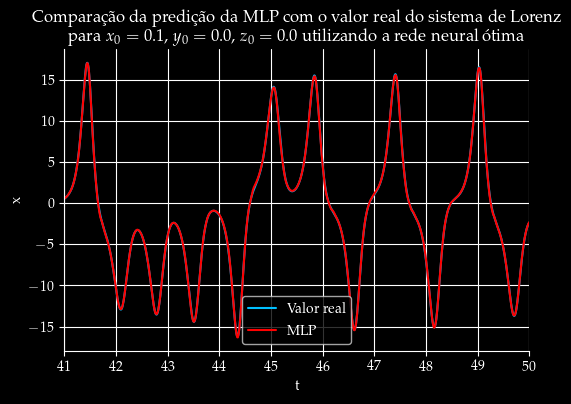

In [34]:
fig, ax = plt.subplots()
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste)+1:,], y_teste, color='DeepSkyBlue', label='Valor real')
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste)+1:,], y_pred, color='Red', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do sistema de Lorenz \npara $x_{0} = $ " + str(estado_inicial[0]) + ", $y_{0} = $ " + str(estado_inicial[1]) + ", $z_{0} = $ " + str(estado_inicial[2]) + " utilizando a rede neural ótima")
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.set_xlim(41, 50)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()

In [39]:
fig, ax = plt.subplots()
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste)+1:,], y_teste, color='DeepSkyBlue', label='Valor real')
ax.plot(instantes_temporais[len(instantes_temporais)-int(len(instantes_temporais)*tam_teste)+1:,], y_pred, color='Red', label='MLP')

ax.set_title("Comparação da predição da MLP com o valor real do sistema de Lorenz \npara $x_{0} = $ " + str(estado_inicial[0]) + ", $y_{0} = $ " + str(estado_inicial[1]) + ", $z_{0} = $ " + str(estado_inicial[2]) + " utilizando a rede neural ótima")
ax.set_ylabel('x')
ax.set_xlabel('t')
ax.set_xlim(41, 50)
    
ax.grid(True)
sns.despine()
ax.legend()

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …